# PyQSOFit on quasar J0242

Example code to fit a quasar's continuum and emission lines and return info on, e.g., continuum slope, line FWHM, line dispersion, EW, peak, etc. The main flows of this example are:

1) We fit the continuum with several components (Power-Law, Polynomial, Fe II, Balmer Continuum) using some line free windows
3) We attempt to fit line complexes one by one, including Mg II, C III], Si IV, C IV and Ly$\alpha$/N V complexes. In each complex, broad and narrow Gaussian profiles are used to fit different emission lines. 

For startup information not repeated here, and for information on longer-wavelength lines than Mg II, see example/example.ipynb.

To adapt this notebook for a different quasar, first create a new directory for that quasar, make a copy of this notebook into that directory, then open the notebook (jupyter notebook notebookname.ipynb) and edit it to apply to your quasar. CHECK AUTOSAVE EVERY TIME YOU MAKE AN EDIT - if autosave isn't working and you can't save manually, take a screenshot of your latest edit and quit and restart the notebook. You'll probably need to re-create your last edit.

To see where to edit, search for USER in this notebook.

 
## Key features (generic)
1) Fit the whole spectra input or fit each line locally using ``wave_range`` parameter
2) Parameter uncertainties can be computed for each parameter. The uncertainties from least-squares fitting is usually not robust, so we do not output those as default results (but the user still can read out this errors through ``lmfit.params``). The best way to calculate the error is using MCMC. In previous versions of the code, we used a Monte Carlo resampling method, which perturbs the flux based on the input error. Computing parameter uncertainties will take longer, but in practice we found that MCMC is not significantly slower than the resampling method and MCMC probably gives more reliable parameter uncertainties and covariances. 
3) A 3rd order polynomial component accounts for dust reddening if any.
4) Iterative sigma clipping can be used to clean the spectrum for absorbed continuum fitting. 
5) One can block several ranges on the spectrum for bad S/N ratio pixels or absorption lines.
6) The code directly saves out the properties of emission lines, e.g., FWHM, line dispersion, EW, Peak, line flux for the broad components and continuum luminosity at 1350, 3000, 5100A.


## To do
* print out continuum luminosities (find where they're reported & describe that)
* PARAM FILES AND describe params to vary, how to rej BAL regions

* MyQSOFit
* make AxesScale an input parameter (PyQSOFit and QSOFit); minor_ticks; xlim & ylim; ...
* dust reddening SMC law in PyQSOFit
* deal with qsopar.fits
* RLF region 1 flux & flux errors - J2318 only
* fix bug of undefined maskregions messing up the spectrum plotting
* May need to change plateid to fieldid for SDSS-V spectra

In [53]:
"""
Step 1: load the necessary packages.
"""

%matplotlib inline
import glob, os, sys, timeit
import matplotlib
import numpy as np
import astropy
import lmfit

sys.path.append('../')
sys.path.append('../src')
sys.path.append('../src/pyqsofit')
import pyqsofit
import emcee  # optional, for MCMC
from pyqsofit.PyQSOFit import QSOFit
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

# Comment out the following lines if you don't like full-window-width cells
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

print(pyqsofit.__path__)

['/Users/phall/Dropbox/RSRCH/PYTHON/PyQSOFit/j0242/../src/pyqsofit']


In [54]:
"""
USER: change the paths below for the input and output files, and change the Author also.
"""

# Path where this notebook can be found
path_name = '.' #os.path.join(pyqsofit.__path__[0], '..', 'example')

# Path to where the data files are stored
path_to_data = '~/Google Drive/My Drive/SDSSV/V0242/Spectra/Both/PBH_uptoDR19/'

# Path to where output files are created
#path_out = os.path.join(pyqsofit.__path__[0], '../', 'example/data/')
path_out = '~/Google Drive/My Drive/SDSSV/V0242/Spectra/Both/PBH_uptoDR19/'

# Name of parameter file to create. Must end with .fits
#param_file_name = 'j0242par.fits'
param_file_name = 'qsopar.fits' # This is currently hardcoded into PyQSOFit.py

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Pat Hall'
primary_hdu = fits.PrimaryHDU(header=hdr0)
print('Author = ', hdr0['Author'])

Author =  Pat Hall


In [86]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
Notation is given in the 'names' parameter below. Each line starts with: 
Vacuum wavelength, 'Name of complex', min_wavelength, max_wavelength, 'Name of component', Number of Gaussians, 
initial_scale, min_scale, max_scale, initial_sig, min_sig, max_sig, maximum_voffset, 
vindex (used to tie velocities of dift components in the same complex),
windex (used to tie widths of dift components in the same complex),
findex (used to tie widths of dift components in the same complex), 
fvalue,
vary

USER: You may need to change the initial guesses for some parameters, and/or uncomment some of the optional line components in a complex.
See PyQSOFit/example/example.ipynb for longer-wavelength lines.
"""

line_priors = np.rec.array([

    (2798.75, 'MgII', 2700, 2900, 'MgII_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    #(2798.75, 'MgII', 2700, 2900, 'MgII_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),

    (1908.73, 'CIII', 1700, 1970, 'CIII_br',   2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 1, 0, 0, 0.01, 1),
    #(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 1, 0, 0.002, 1),
    #(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
    #(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
    #(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
    #(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

    (1549.06, 'CIV', 1500, 1700, 'CIV_br', 2, 0.0, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 0, 0, 0, 0.05, 1),
    # (1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 1, 1, 0, 0.002, 1),
    #(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    #(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.0, 0.0, 1e10, 1e-3, 5e-4,   0.00169, 0.008, 1, 1, 0, 0.002, 1),
    (1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
    (1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.0, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

    (1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 1, 1.0, 1),
    (1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 1, 1.0, 1),
    #(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
    #(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

    (1215.67, 'Lya', 1150, 1290, 'Lya_br', 3, 0.0, 0.0, 1e10, 5e-3, 0.002, 0.05, 0.02, 0, 0, 0, 0.05, 1),
    (1240.14, 'Lya', 1150, 1290, 'NV1240', 1, 0.0, 0.0, 1e10, 2e-3, 0.001, 0.01, 0.005, 0, 0, 0, 0.002, 1),
    # (1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.0, 0.0, 1e10, 1e-3, 5e-4, 0.00169, 0.01, 0, 0, 0, 0.002, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

print('Line fitting initialized.')

Line fitting initialized.


In [87]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.

USER: you may need to change the continuum fitting windows, or (less likely) some of the fitting parameters.
"""

conti_windows = np.rec.array([
    (1275., 1290.),
    (1350., 1360.),
    #(1500., 1510.),
    (1690., 1705.),
    (1770., 1810.),
    (1970., 2400.),
    (2480., 2675.),
    (2925., 3000.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda]
    ('PL_norm',     1.0,   0.0,   1e10,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -5.0,  3.0,   1), # Slope of the power-law (PL) continuum
    ('Balmer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  1), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'

hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

print('Continuum fitting parameters:')
Table(conti_priors)

Continuum fitting parameters:


<Table length=14>
  parname   initial   min        max       vary
  bytes20   float32 float32    float32    int32
----------- ------- ------- ------------- -----
 Fe_uv_norm     0.0     0.0 10000000000.0     1
 Fe_uv_FWHM  3000.0  1200.0       18000.0     1
Fe_uv_shift     0.0   -0.01          0.01     1
 Fe_op_norm     0.0     0.0 10000000000.0     1
 Fe_op_FWHM  3000.0  1200.0       18000.0     1
Fe_op_shift     0.0   -0.01          0.01     1
    PL_norm     1.0     0.0 10000000000.0     1
   PL_slope    -1.5    -5.0           3.0     1
Balmer_norm     0.0     0.0 10000000000.0     1
  Balmer_Te 15000.0 10000.0       50000.0     1
 Balmer_Tau     0.5     0.1           2.0     1
  conti_a_0     0.0     nan           nan     1
  conti_a_1     0.0     nan           nan     1
  conti_a_2     0.0     nan           nan     1

In [88]:
"""
In this table, customize some key parameters for the result measurements.

USER: you may need to change the wavelengths at which the continuum luminosity is output,
and/or the wavelengths in between which the Fe II emission strength is measured.
"""

measure_info = Table(
    [
        [[1350, 2500]], # wavelengths unaffected by absorption in J0242
        # [[1350, 1450, 3000, 4200, 5100]],
        [[
            # [1200, 3000], # full extent of Fe II UV coverage common to all our spectra
            [2240, 2650], # subset of wavelengths where Fe II is usually strongest
        ]]
    ],
    names=([
        'cont_loc', # first list of wavelengths above, stored as conti_wave in PyQSOFit
        'Fe_flux_range' # second 
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])

""" 
Write the parameter file to disk
"""
hdu_list.writeto(os.path.join(path_name, param_file_name), overwrite=True)
print("Created parameter file ", os.path.join(path_name, param_file_name))
# print table:
Table(line_priors)

Created parameter file  ./qsopar.fits


<Table length=9>
 lambda compname  minwav  maxwav   linename  ngauss  inisca  minsca     maxsca     inisig  minsig  maxsig   voff  vindex windex findex  fvalue  vary
float32 bytes20  float32 float32   bytes20   int32  float32 float32    float32    float32 float32 float32 float32 int32  int32  int32  float32 int32
------- -------- ------- ------- ----------- ------ ------- ------- ------------- ------- ------- ------- ------- ------ ------ ------ ------- -----
2798.75     MgII  2700.0  2900.0     MgII_br      2     0.0     0.0 10000000000.0   0.005   0.004    0.05   0.015      0      0      0    0.05     1
1908.73     CIII  1700.0  1970.0     CIII_br      2     0.0     0.0 10000000000.0   0.005   0.004    0.05   0.015      1      0      0    0.01     1
1549.06      CIV  1500.0  1700.0      CIV_br      2     0.0     0.0 10000000000.0   0.005   0.004    0.05   0.015      0      0      0    0.05     1
1640.42      CIV  1500.0  1700.0 HeII1640_br      1     0.0     0.0 10000000000.0   0.005  0.0025    0.02   0.008      1      1      0   0.002     1
1663.48      CIV  1500.0  1700.0 OIII1663_br      1     0.0     0.0 10000000000.0   0.005  0.0025    0.02   0.008      1      1      0   0.002     1
1402.06     SiIV  1290.0  1450.0   SiIV_OIV1      1     0.0     0.0 10000000000.0   0.005   0.002    0.05   0.015      1      1      1     1.0     1
1396.76     SiIV  1290.0  1450.0   SiIV_OIV2      1     0.0     0.0 10000000000.0   0.005   0.002    0.05   0.015      1      1      1     1.0     1
1215.67      Lya  1150.0  1290.0      Lya_br      3     0.0     0.0 10000000000.0   0.005   0.002    0.05    0.02      0      0      0    0.05     1
1240.14      Lya  1150.0  1290.0      NV1240      1     0.0     0.0 10000000000.0   0.002   0.001    0.01   0.005      0      0      0   0.002     1

In [89]:
"""
Step 2: read in the spectrum
"""

# USER: list the paths to your SDSS spectra here, along with an epoch designation for each of them.
# Or read in a table from a file that has this information and choose the desired row.

# FITS data
dataflag='fits'
# data = fits.open(os.path.join(path_to_data, 'spec-0408-51821-0576.fits')); epoch = '0'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-0707-52177-0332.fits')); epoch = '1'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-0706-52199-0617.fits')); epoch = '2'; maskregions=np.array([[1440.,1480.]])
##data = fits.open(os.path.join(path_to_data, '')); epoch = '3' # UVES 53619; not yet available
# data = fits.open(os.path.join(path_to_data, 'spec-3651-55247-0676.fits')); epoch = '4'; maskregions=np.array([[1200.,1213.],[1222.5,1239.],[1300.,1330.],[1420.,1480.],[1528.,1545.]])
# data = fits.open(os.path.join(path_to_data, 'spec-4240-55455-0754.fits')); epoch = '5'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-7821-57279-0328.fits')); epoch = '6'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-9381-57758-0079.fits')); epoch = '7'; maskregions=np.array([[1440.,1480.]]) # DR16 catalog
data = fits.open(os.path.join(path_to_data, 'spec-9381-58073-0079.fits')); epoch = '8'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-015015-59166-4401882076.fits')); epoch = '9'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-015015-59169-4401882076.fits')); epoch = '10'; maskregions=np.array([[1440.,1480.]]) # DR19 catalog
# data = fits.open(os.path.join(path_to_data, 'spec-015015-59192-4401882076.fits')); epoch = '11'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-015015-59222-4401882076.fits')); epoch = '12'; maskregions=np.array([[1440.,1480.]])
# data = fits.open(os.path.join(path_to_data, 'spec-allepoch-59222-4401882076.fits')); epoch = 'A'; maskregions=np.array([[1440.,1480.]])
#dataflag='csv' # UNCOMMENT TO LOAD CSV data for epoch 13 (DESI)

# USER: If analyzing multiple epochs for same object, use the same redshift for all epochs
z = 2.06 # Use one redshift for all J0242 data
#z = data[2].data['z'][0]  # Redshift
#epoch = '0' # Epoch label for only one spectrum

# CSV data - NOT YET WORKING
if dataflag=='csv':
    data = ascii.read(os.path.join(path_to_data, 'spec-desi-59490-39627803527745007.csv')); epoch = '13'; maskregions=np.array([[1440.,1480.]]) # DESI
    ra = 40.591142; dec = 0.820189; plateid = 'desi'; mjd=59490; fiberid='39627803527745007' # DESI
    lam = data['Wavelength']; flux = data['Flux']; err = data['Error'] # DESI
else: 
    lam = 10 ** data[1].data['loglam']  # OBS wavelength [A]
    flux = data[1].data['flux']  # OBS flux [erg/s/cm^2/A]
    err = 1 / np.sqrt(data[1].data['ivar'])  # 1 sigma error
    if epoch=='A':
        ra = 40.591142; dec = 0.820189
        plateid='allepoch'
        mjd = 59222  # SDSS MJD
    else:
    # following is optional (not used by the code for calculations, but included in output figure)
        ra = data[0].header['plug_ra']  # RA
        dec = data[0].header['plug_dec']  # DEC
        plateid = data[0].header['plateid']  # SDSS plate ID
        mjd = data[0].header['mjd']  # SDSS MJD
        if (plateid < 15000):
            fiberid = data[0].header['fiberid']  # SDSS fiber ID
        else:
            fiberid = data[2].data['CATALOGID'].item()  # SDSS-V catalog ID

print('ra, dec, plateid, mjd, fiberid = ', ra, dec, plateid, mjd, fiberid)
print(''); print('Absorption regions to mask (maskregions):')
print(maskregions)

ra, dec, plateid, mjd, fiberid =  40.59114399999999 0.820204 9381 58073 79

Absorption regions to mask (maskregions):
[[1440. 1480.]]


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Balmer_Tau        0.5      0.1        2     None    False     None     None
Balmer_Te     1.5e+04    1e+04    5e+04     None    False     None     None
Balmer_norm         0        0    1e+10     None    False     None     None
Fe_op_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_op_norm          0        0    1e+10     None    False     None     None
Fe_op_shift         0    -0.01     0.01     None    False     None     None
Fe_uv_FWHM       3000     1200  1.8e+04     None     True     None     None
Fe_uv_norm          0        0    1e+10     None     True     None     None
Fe_uv_shift         0    -0.01     0.01     None     True     None     None
PL_norm             1        0    1e+10     None     True     None     None
PL_slope         -1.5       -5        3     None     True     None     None
conti_a_0           0     -inf      inf     None    False     None     None
conti_a_1 

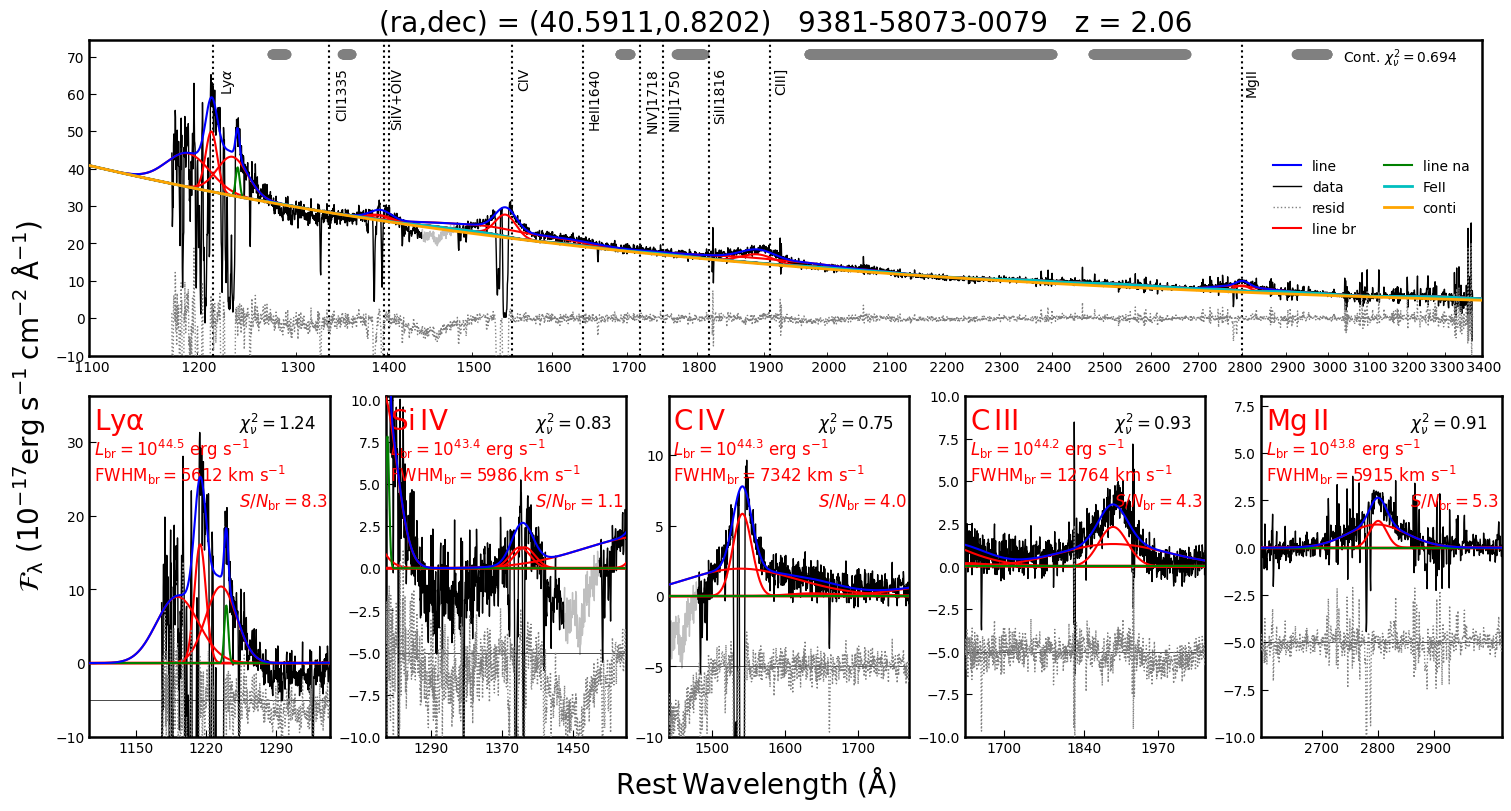

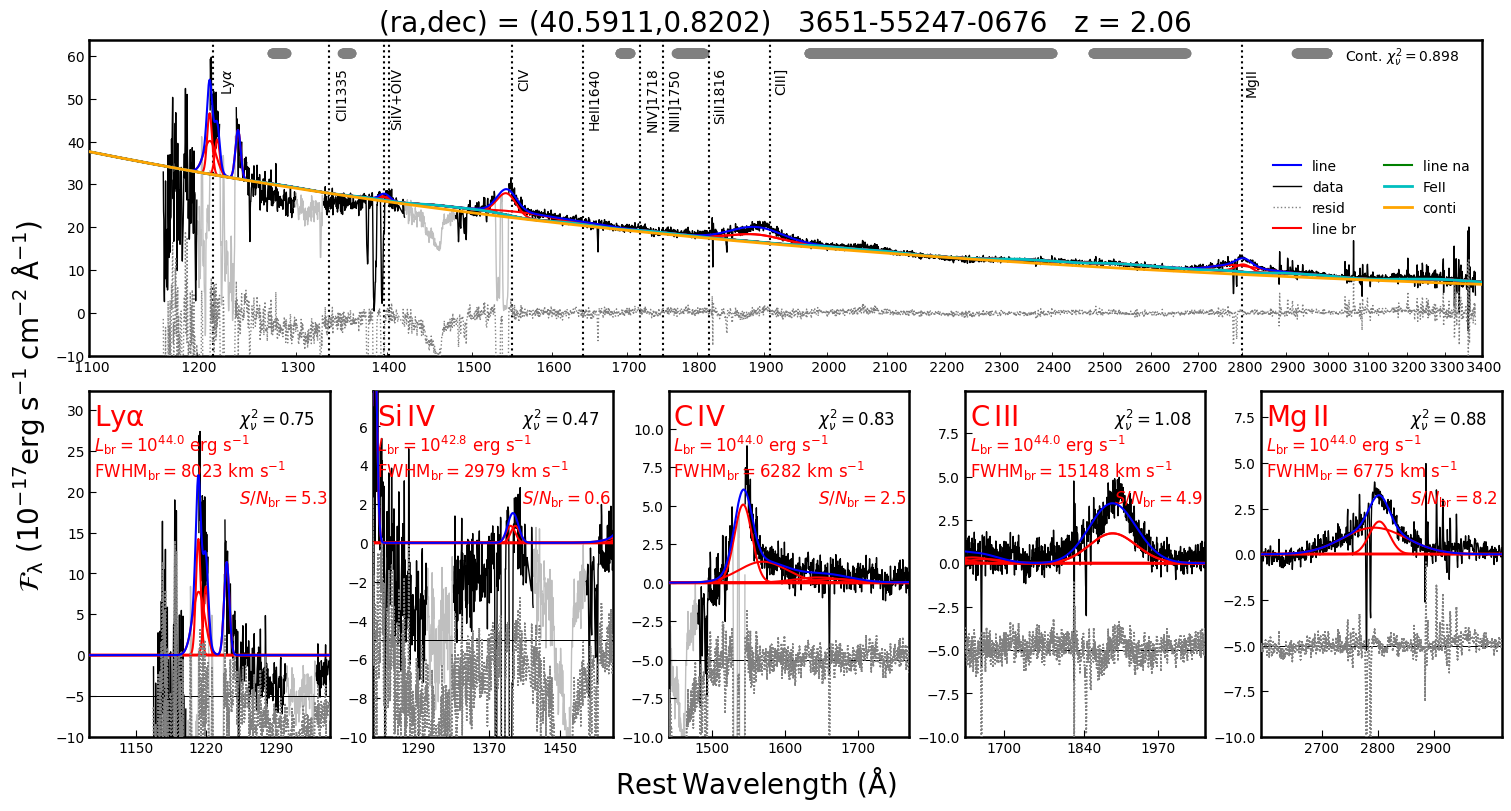

In [90]:
"""
Step 3: fit the spectrum.
"""

# Prepare data
q_mle = QSOFit(lam, flux, err, z, epoch, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_name)

# Double check the installation path with the PCA / Fe template files
# print('install path:', q_mle.install_path)

# Change it if you installed them somewhere else
#q_mle.install_path = '...'

start = timeit.default_timer()
# Do the fitting

q_mle.Fit(name=None,  # customize the name of given targets. Default: plate-mjd-fiber
          # prepocessing parameters
          nsmooth=1,  # do n-pixel smoothing to the raw input flux and err spectra
          and_mask=False,  # delete the and masked pixels
          or_mask=False,  # delete the or masked pixels
          reject_badpix=True,  # reject 10 most possible outliers by the test of pointDistGESD
          deredden=True,  # correct the Galactic extinction
          wave_range=None,  # trim input wavelength
          # USER: wave_mask is where to specify regions to ignore due to BAL troughs:
          #wave_mask=np.array([[1440.,1480.]]),  # 2-D array, mask the given range(s)
          #wave_mask=np.array([[1440.,1480.], [1820.,1840.]]),  # 2-D array, mask the given range(s)
          wave_mask=maskregions,  # 2-D array, mask the given range(s)
          #wave_mask=None,  # 2-D array, mask the given range(s)

          # host decomposition parameters
          decompose_host=False,  # If True, the host galaxy-QSO decomposition will be applied

          host_prior=False, # If True, the code will adopt prior-informed method to assist decomposition. Currently, only 'CZBIN1' and 'DZBIN1' model for QSO PCA are available. And the model for galaxy must be PCA too.
          host_prior_scale=0.2, # scale of prior panelty. Usually, 0.2 works fine for SDSS spectra. Adjust it smaller if you find the prior affect the fitting results too much.

          host_line_mask=True, # If True, the line region of galaxy will be masked when subtracted from original spectra.
          decomp_na_mask=True, # If True, the narrow line region will be masked when perform decomposition
          qso_type='CZBIN1', # PCA template name for quasar
          npca_qso=10, # number of quasar templates
          host_type='PCA', # template name for galaxy
          npca_gal=5, # number of galaxy templates
          
          # continuum model fit parameters
          Fe_uv_op=True,  # If True, fit continuum with UV and optical FeII template
          #poly=True,  # If True, fit continuum with the polynomial component to account for the dust reddening
          poly=False,  # If True, fit continuum with the polynomial component to account for the dust reddening
          BC=False,  # If True, fit continuum with Balmer continua from 1000 to 3646A
          initial_guess=None,  # Initial parameters for continuum model, read the annotation of this function for detail
          rej_abs_conti=True,  # USER: Keep as True to iterately reject 3 sigma outlier absorption pixels in the continuum
          n_pix_min_conti=100,  # Minimum number of negative pixels for host continuuum fit to be rejected

          # emission line fit parameters
          linefit=True,  # If True, the emission line will be fitted using info from qsopar.fits, stored as 'linelist' in the code
          rej_abs_line=True, # USER: Keep as True to iterately reject 3 sigma outlier absorption pixels in the emission lines

          # fitting method selection
          MC=False,
          # If True, do Monte Carlo resampling of the spectrum based on the input error array to produce the MC error array
          MCMC=False,
          # If True, do Markov Chain Monte Carlo sampling of the posterior probability densities to produce the error array
          nsamp=200,
          # The number of trials of the MC process (if MC=True) or number samples to run MCMC chain (if MCMC=True)

          # advanced fitting parameters
          nburn=20,  # The number of burn-in samples to run MCMC chain
          nthin=10,  # To set the MCMC chain returns every n samples
          epsilon_jitter=0.,
          # Initial jitter for every initial guass to avoid local minimum. (Under test, not recommanded to change)

          # customize the results
          save_result=False,  # If True, all the fitting results will be saved to a fits file
          save_fits_name=None,  # The output name of the result fits
          save_fits_path=path_out,  # The output path of the result fits
          plot_fig=True,  # If True, the fitting results will be plotted
          save_fig=False,  # If True, the figure will be saved
          plot_corner=True,  # Whether or not to plot the corner plot results if MCMC=True

          # debugging mode
          verbose=True,  # turn on (True) or off (False) debugging output

          # sublevel parameters for figure plot and emcee
          kwargs_plot={
              'save_fig_path': '.',  # The output path of the figure
              'broad_fwhm'   : 1200  # km/s, lower limit that code decide if a line component belongs to broad component
          },
          kwargs_conti_emcee={},
          kwargs_line_emcee={})

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

The gray shaded bars at the top are the continuum windows used in the fitting.<br>
__Now you are already done with the QSO fitting part!__

__Step 3(optional): Compute parameter uncertainties using MC resampling__:<br>
For comparison, let's fit the same quasar spectrum, but this time using MC resampling of the spectrum based on the spectrum error. Obviously, this will take significantly longer depending on the number of samples you want to run `nsamp`. 

In [91]:
q_mc = QSOFit(lam, flux, err, z, epoch, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_name)

start = timeit.default_timer()
# Do the fitting   

q_mc.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
         wave_mask=None, decompose_host=True, host_prior=False, decomp_na_mask=True, npca_gal=5, npca_qso=10, qso_type='CZBIN1',\
         Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MC=True, nsamp=200, linefit=True, \
         save_result=True, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None, verbose=True)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
Balmer_Tau        0.5      0.1        2     None    False     None     None
Balmer_Te     1.5e+04    1e+04    5e+04     None    False     None     None
Balmer_norm         0        0    1e+10     None    False     None     None
Fe_op_FWHM       3000     1200  1.8e+04     None    False     None     None
Fe_op_norm          0        0    1e+10     None    False     None     None
Fe_op_shift         0    -0.01     0.01     None    False     None     None
Fe_uv_FWHM       3000     1200  1.8e+04     None     True     None     None
Fe_uv_norm          0        0    1e+10     None     True     None     None
Fe_uv_shift         0    -0.01     0.01     None     True     None     None
PL_norm             1        0    1e+10     None     True     None     None
PL_slope         -1.5       -5        3     None     True     None     None
conti_a_0           0     -inf      inf     None     True     None     None
conti_a_1 

Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
CIV_br_1_dwave              0   -0.015    0.015     None     True     None     None
CIV_br_1_scale              0        0    1e+10     None     True     None     None
CIV_br_1_sigma          0.005    0.004     0.05     None     True     None     None
CIV_br_2_dwave              0   -0.015    0.015     None     True     None     None
CIV_br_2_scale              0        0    1e+10     None     True     None     None
CIV_br_2_sigma          0.005    0.004     0.05     None     True     None     None
HeII1640_br_1_dwave         0   -0.008    0.008     None     True     None     None
HeII1640_br_1_scale         0        0    1e+10     None     True     None     None
HeII1640_br_1_sigma     0.005   0.0025     0.02     None     True     None     None
OIII1663_br_1_dwave         0   -0.008    0.008     None    False HeII1640_br_1_dwave     None
OIII1663_br_1_scale         0        0    1e+10     None     Tr

__Step 3(optional): Compute parameter uncertaintines using MCMC__:<br>
For comparison, let's fit the same quasar spectrum, but this time using MCMC to get uncertainties on the parameters. Obviously, this will take significantly longer depending on the number of samples you want to run. You will need the ``pandas`` and ``emcee`` packages to do this. To visualize the posterior parameter distributions and their covariances, you will need the ``corner`` package. It's also usually a good idea to perturb the parameter starting points by a small random number using the ``epsilon_jitter`` argument, and exclude unnecessary line components, otherwise you may get an ''Initial state has a large condition number'' error.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:30<00:00, 13.13it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [50.8135963  49.56819771 35.60771581 48.23355268 38.96545289 45.86097722
 49.380584   49.81818065]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 322.11it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 12 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [35.33608427 35.54260179 34.2334148  32.95027196 34.87062572 32.5066117
 33.90388603 35.73040792 33.33454078 34.40051546 36.12415855 34.74133358]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 233.49it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [20.76039682 17.43558144 20.06576572]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 266.43it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [47.86067061 40.00714642 45.14084528 44.15297474 43.06464661 51.15161302
 39.66006923 42.88777188 50.51631892 39.05353845]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 261.54it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [30.50242183 23.83487051 37.49273703 29.71289263 29.95284236]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:01<00:00, 330.72it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 8;
tau: [30.01953216 26.77507394 31.4956041  30.08750218 28.58509728 27.76696494]
ASCII of continuum saved to:
/Users/phall/Dropbox/RSRCH/PYTHON/PyQSOFit/j0242/None_58073_8_PQF_RLF1Fix.dat
Parameters used for continuum fitting saved to:
/Users/phall/Dropbox/RSRCH/PYTHON/PyQSOFit/j0242/None_58073_8_pp.txt
QSOFit-reduced spectrum saved to:
/Users/phall/Dropbox/RSRCH/PYTHON/PyQSOFit/j0242/None_58073_8_PQF-RAW.dat

Fitting finished in 87.1s


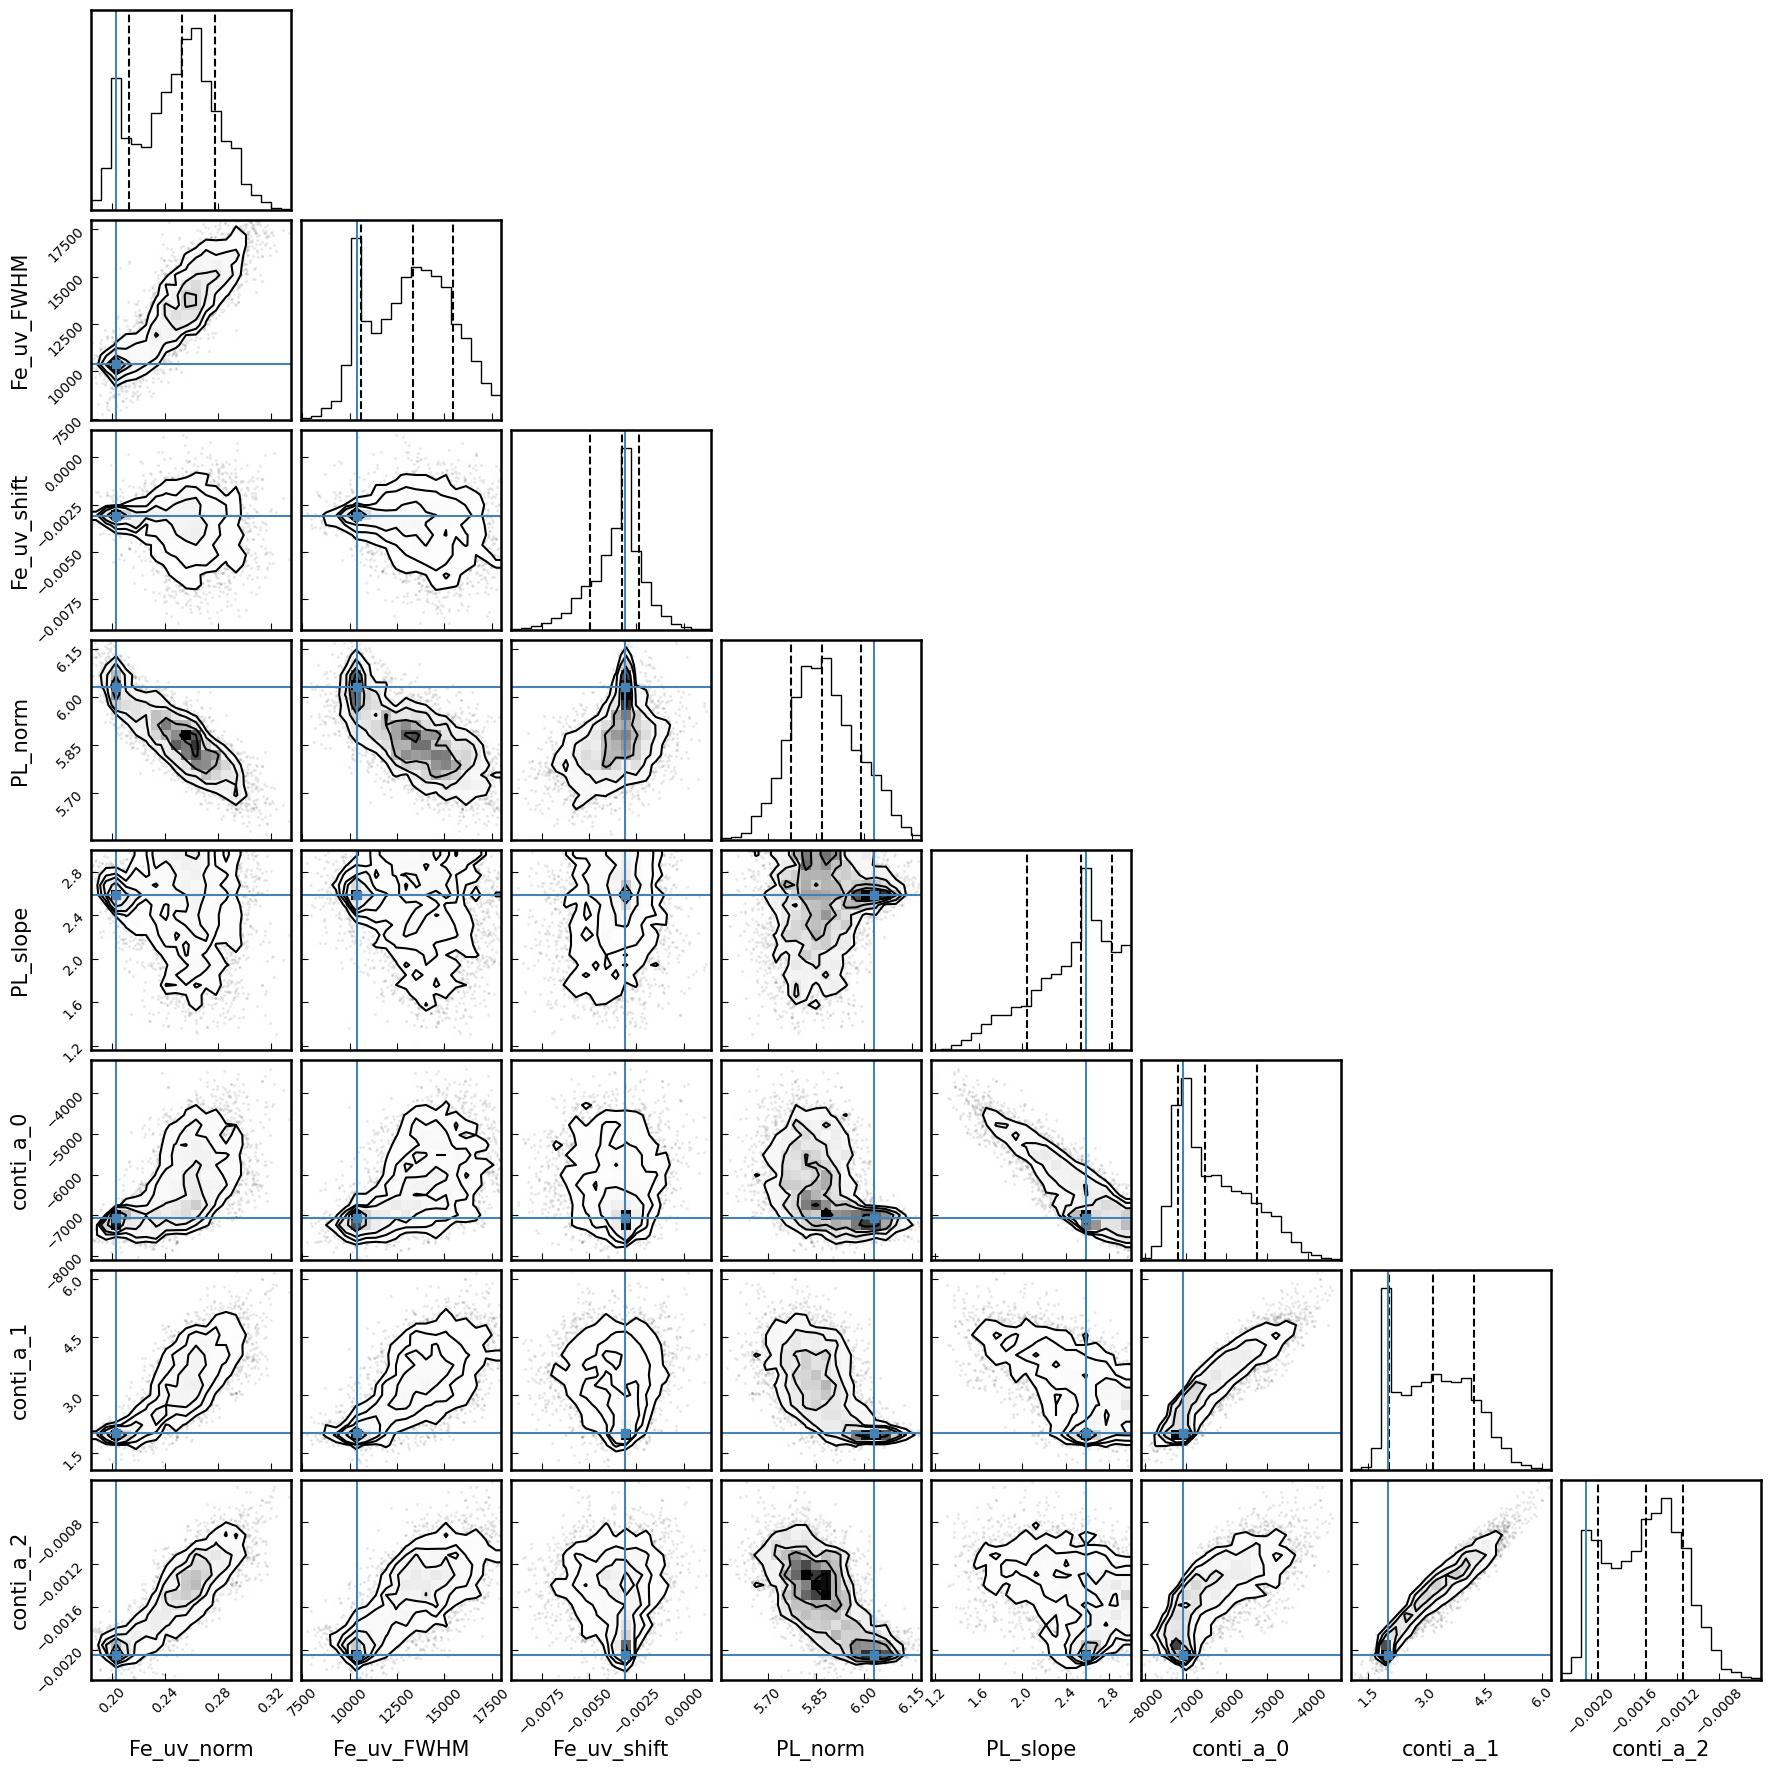

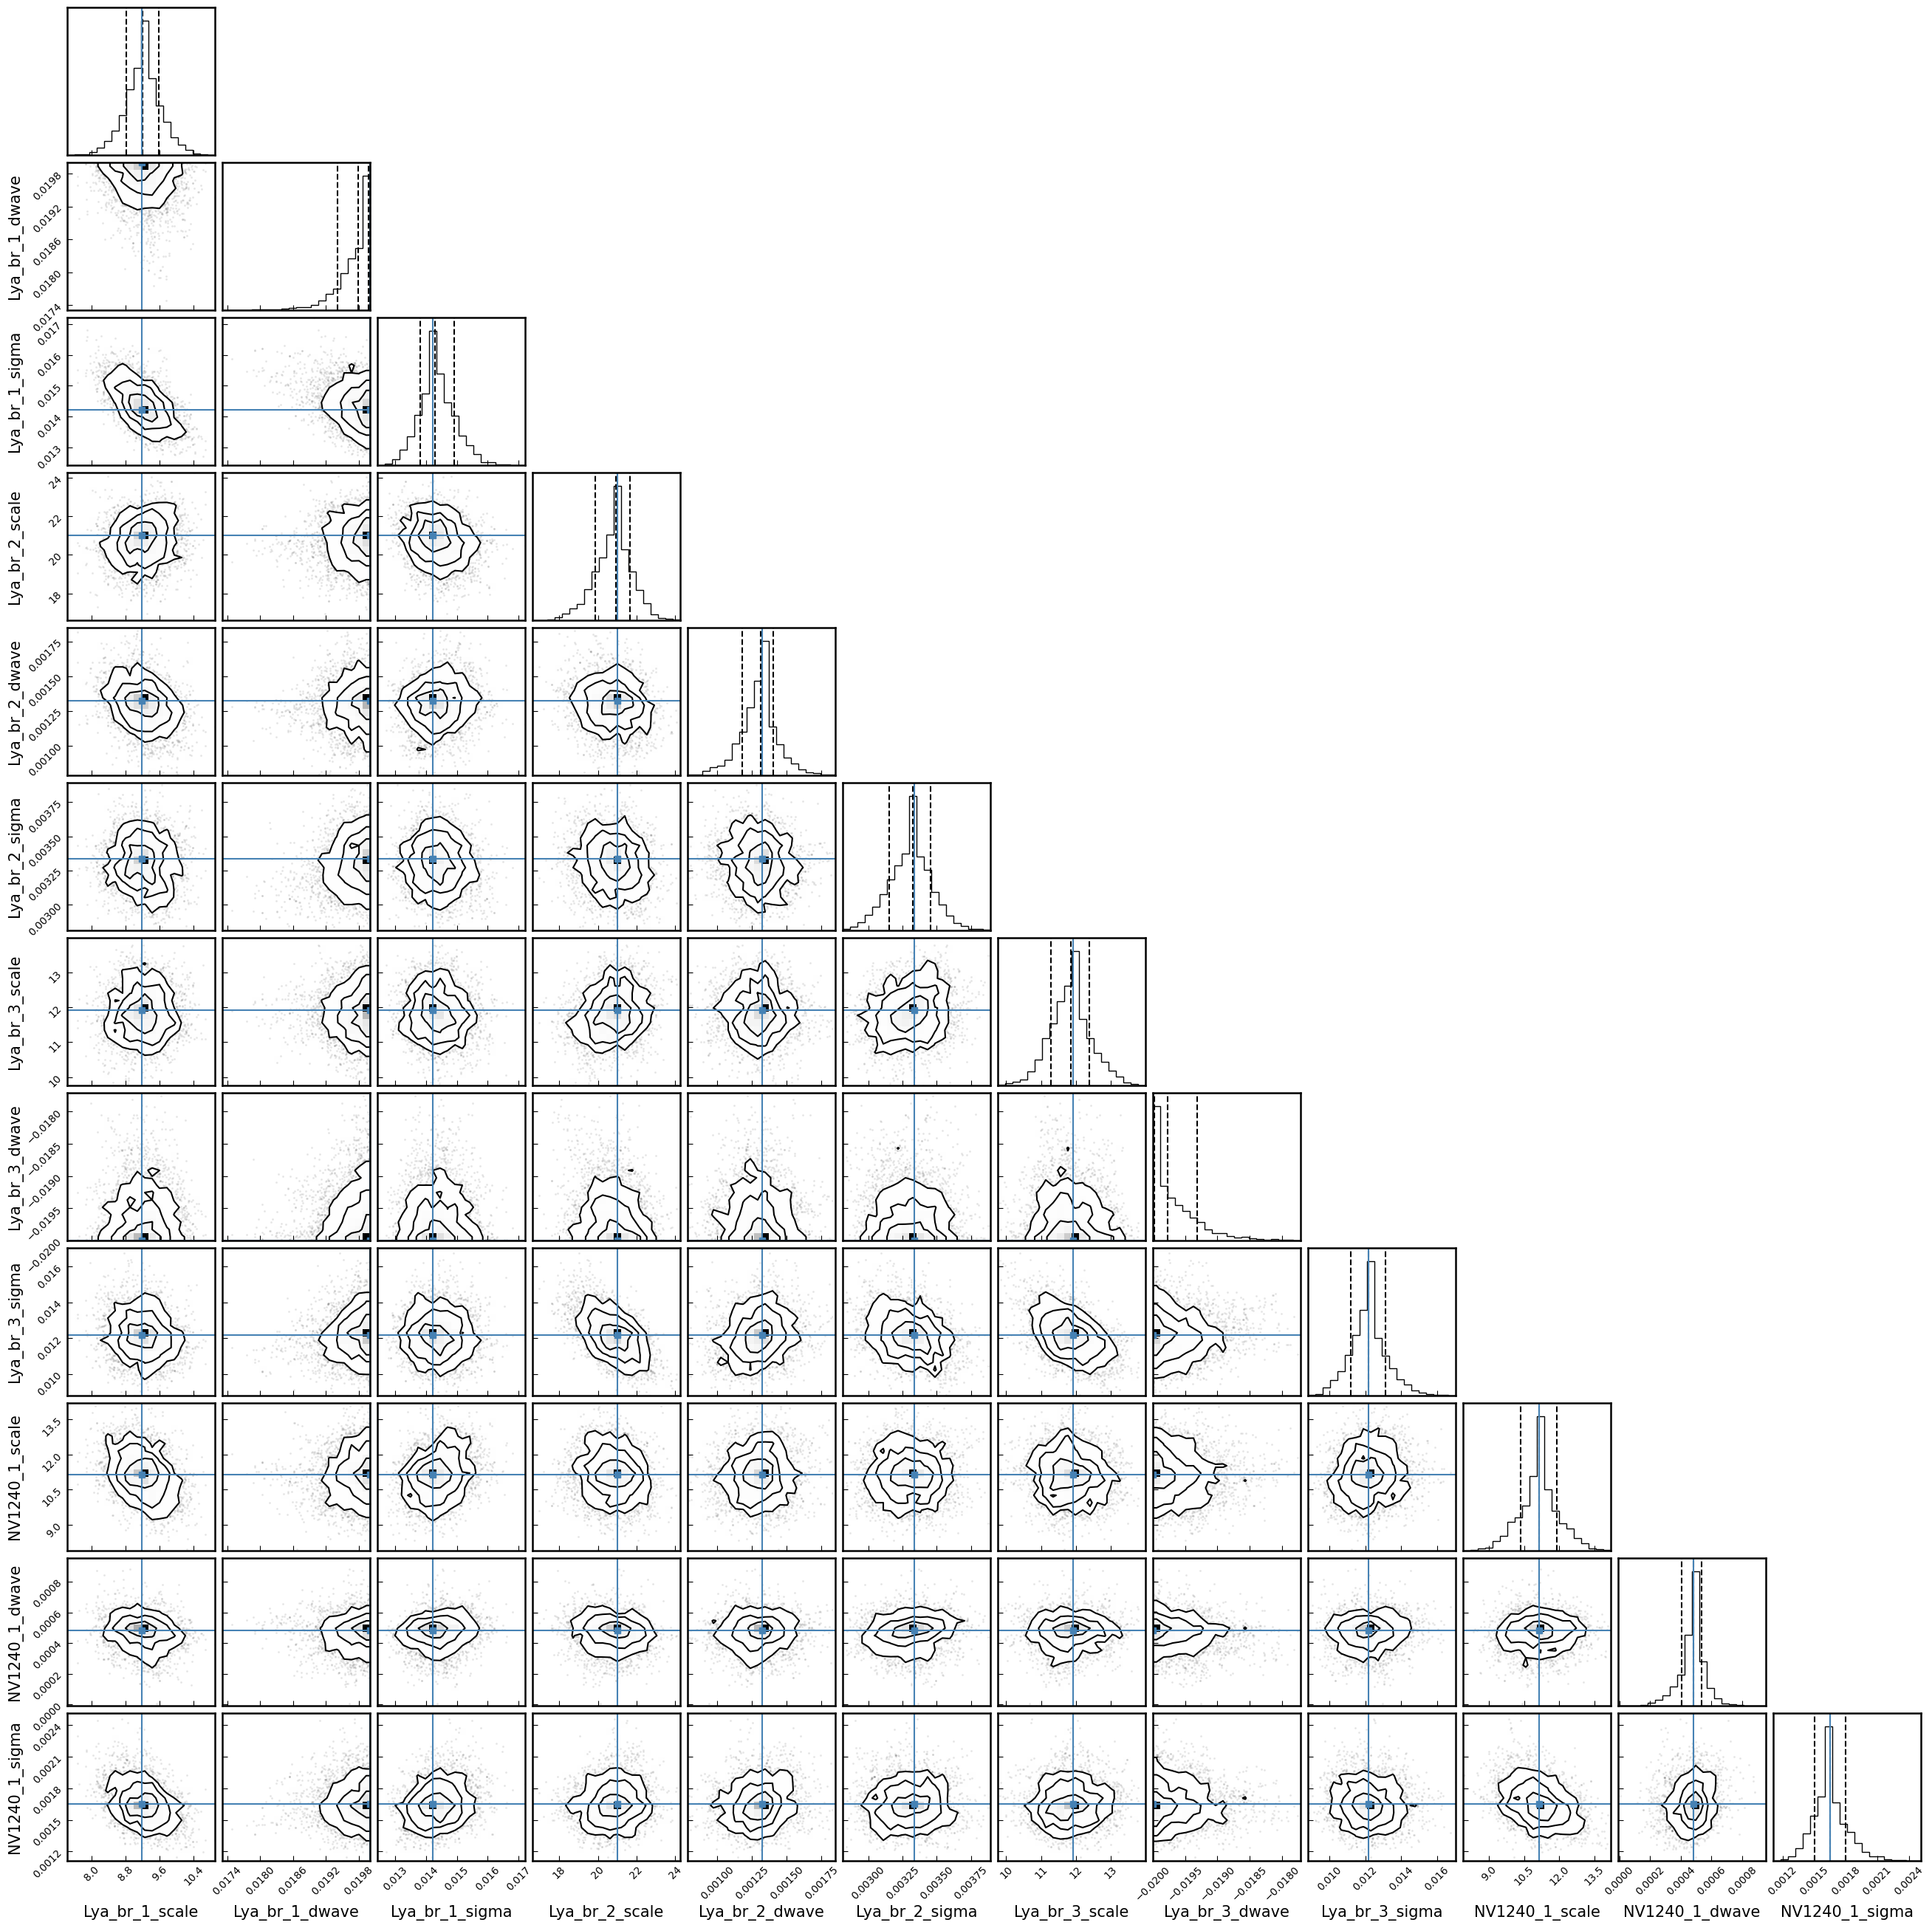

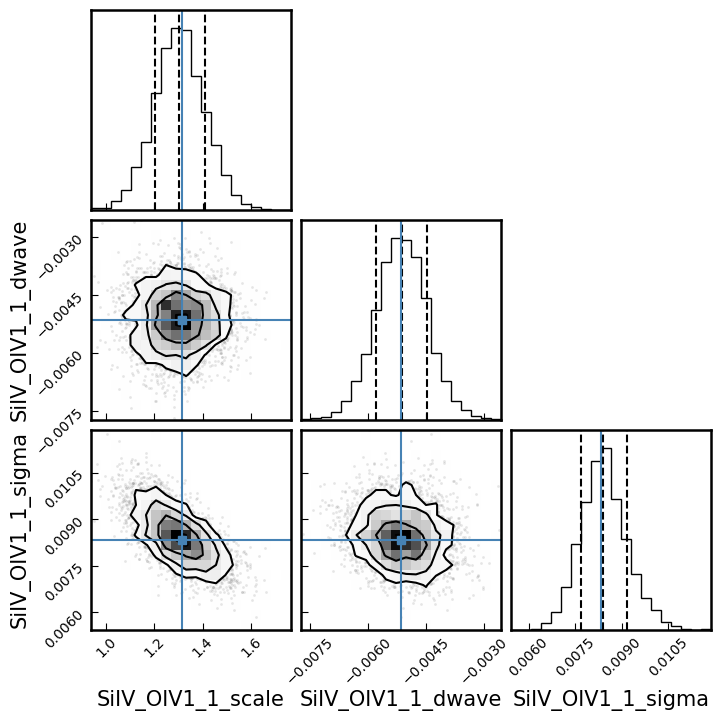

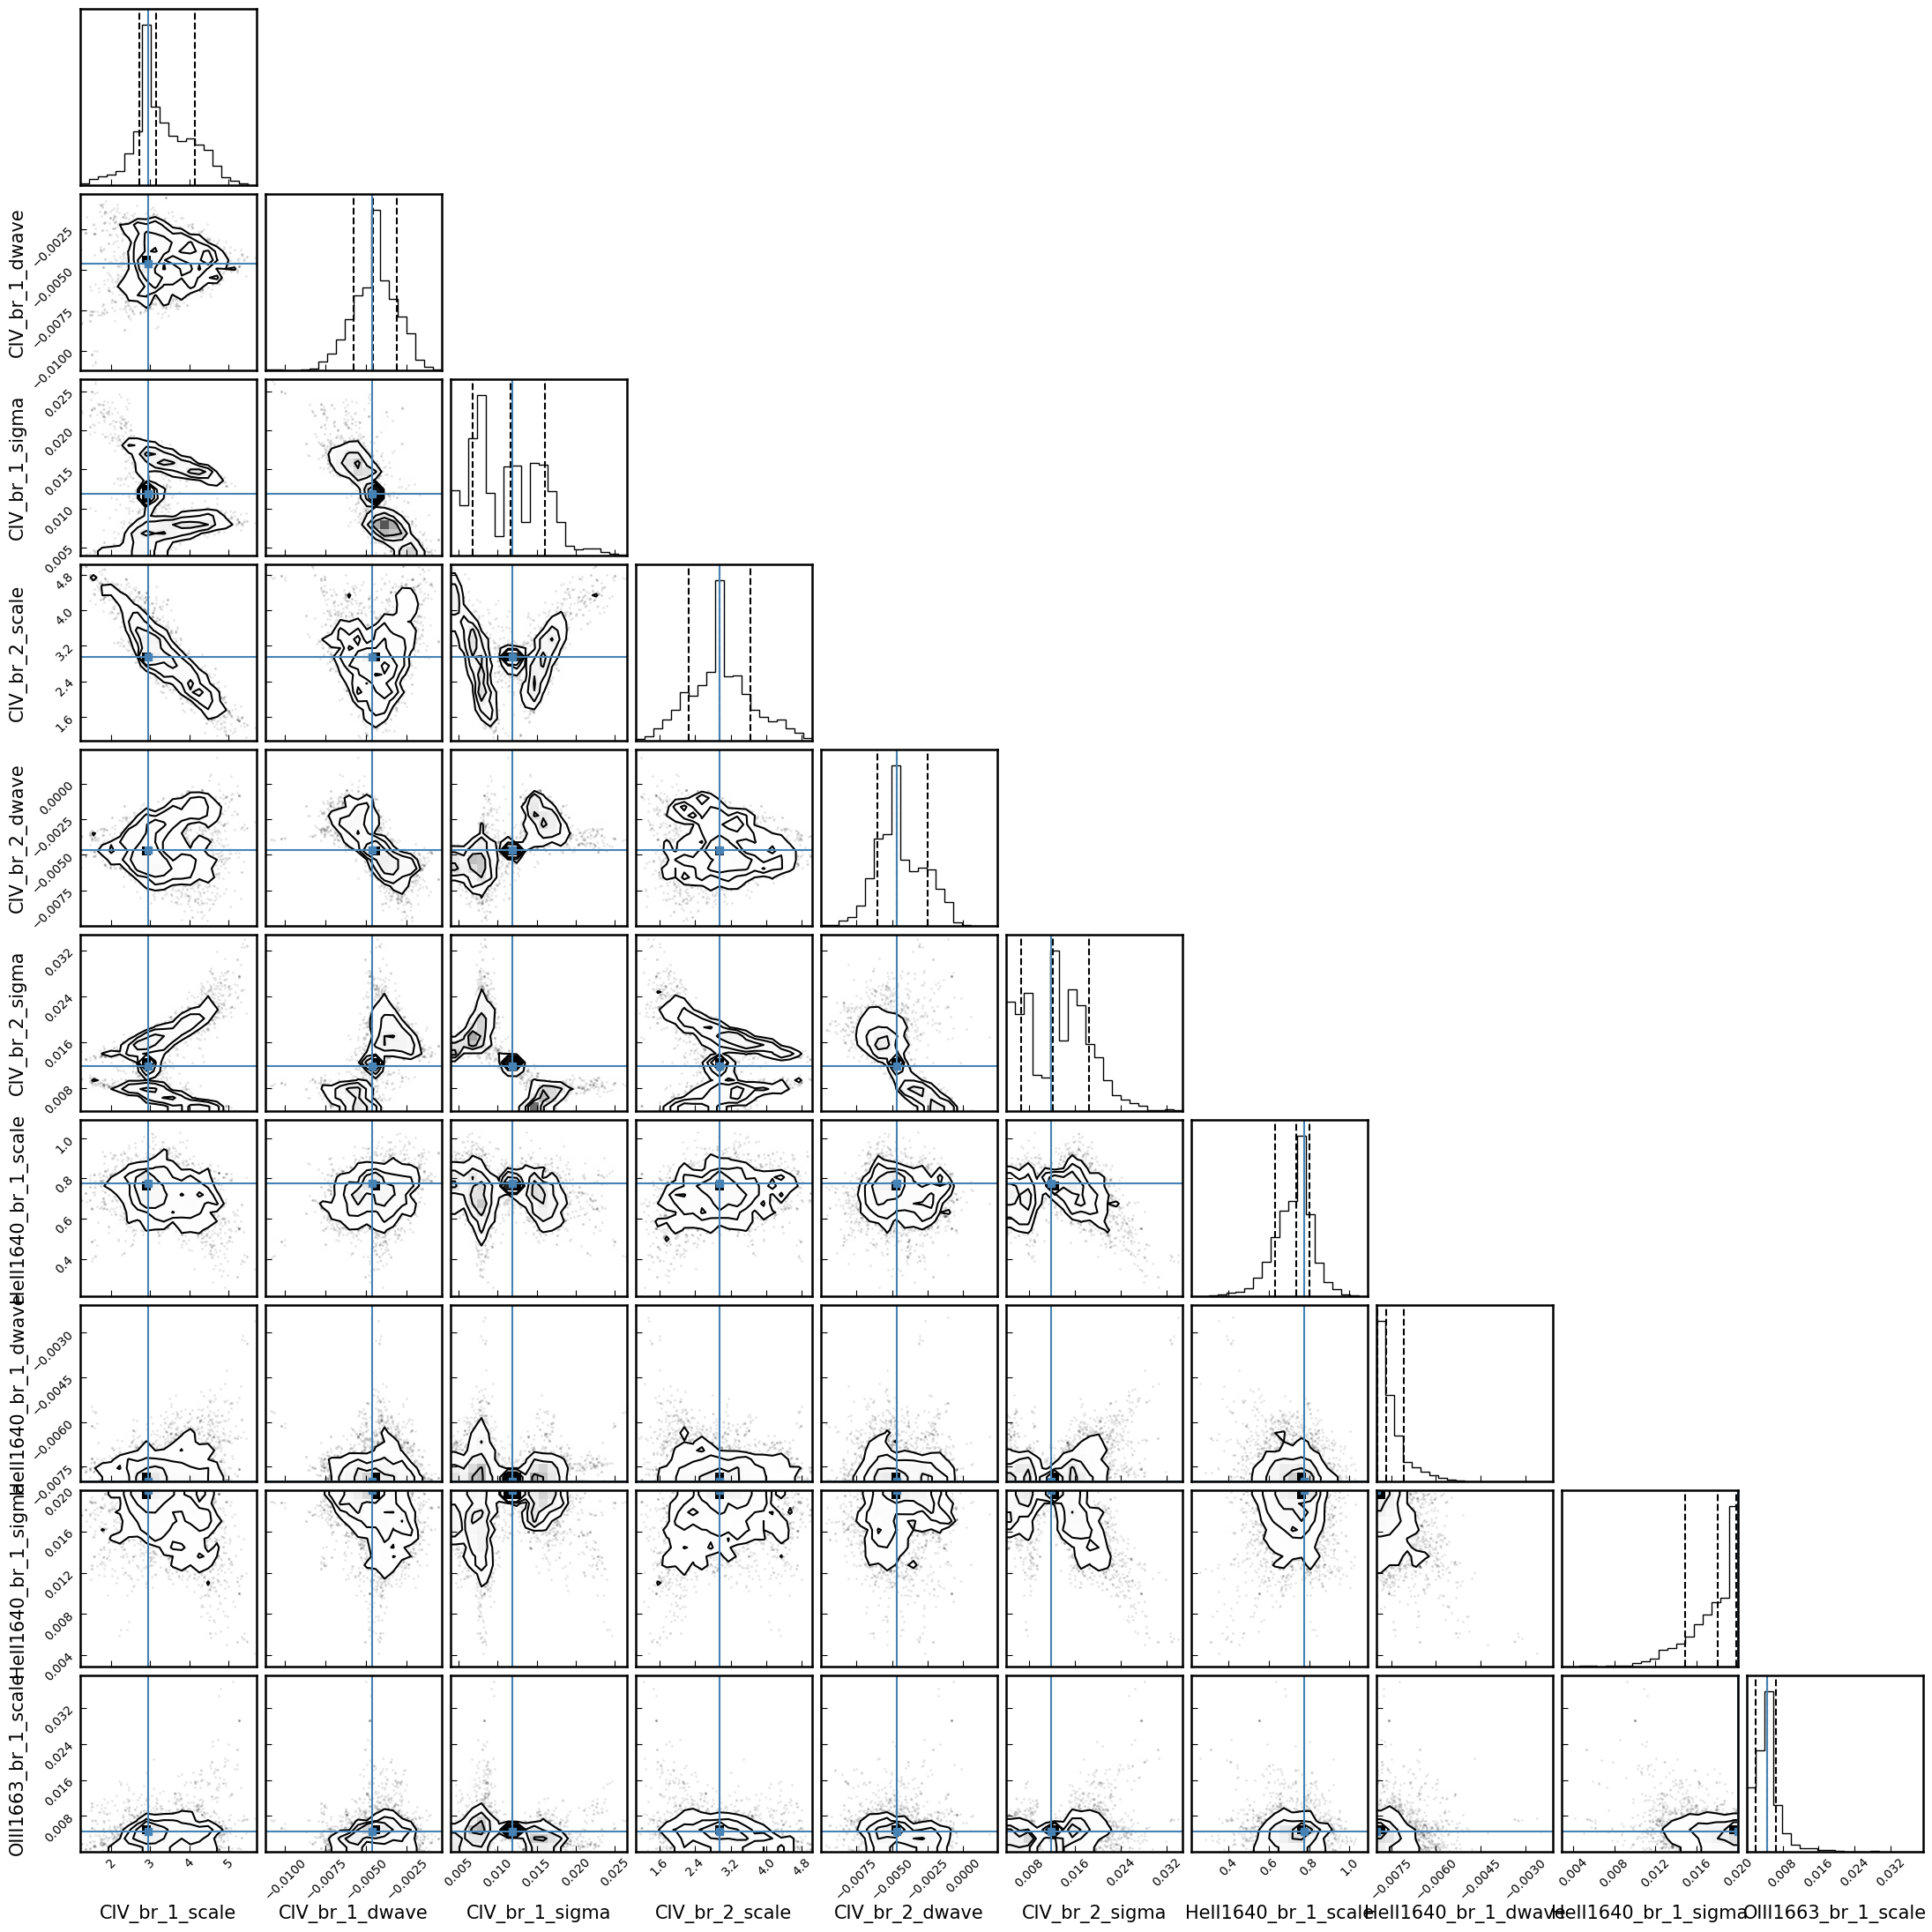

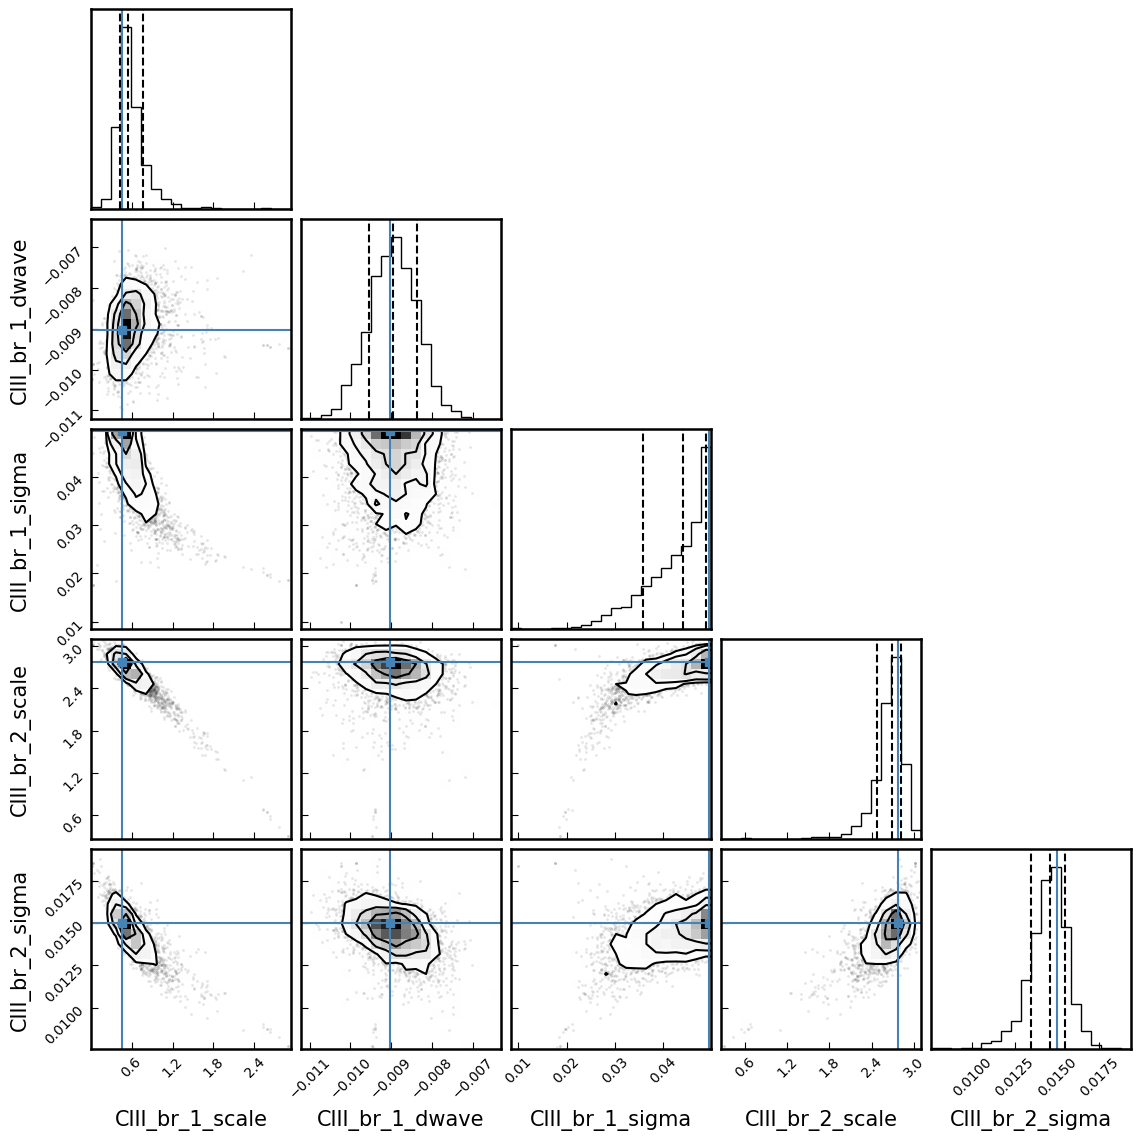

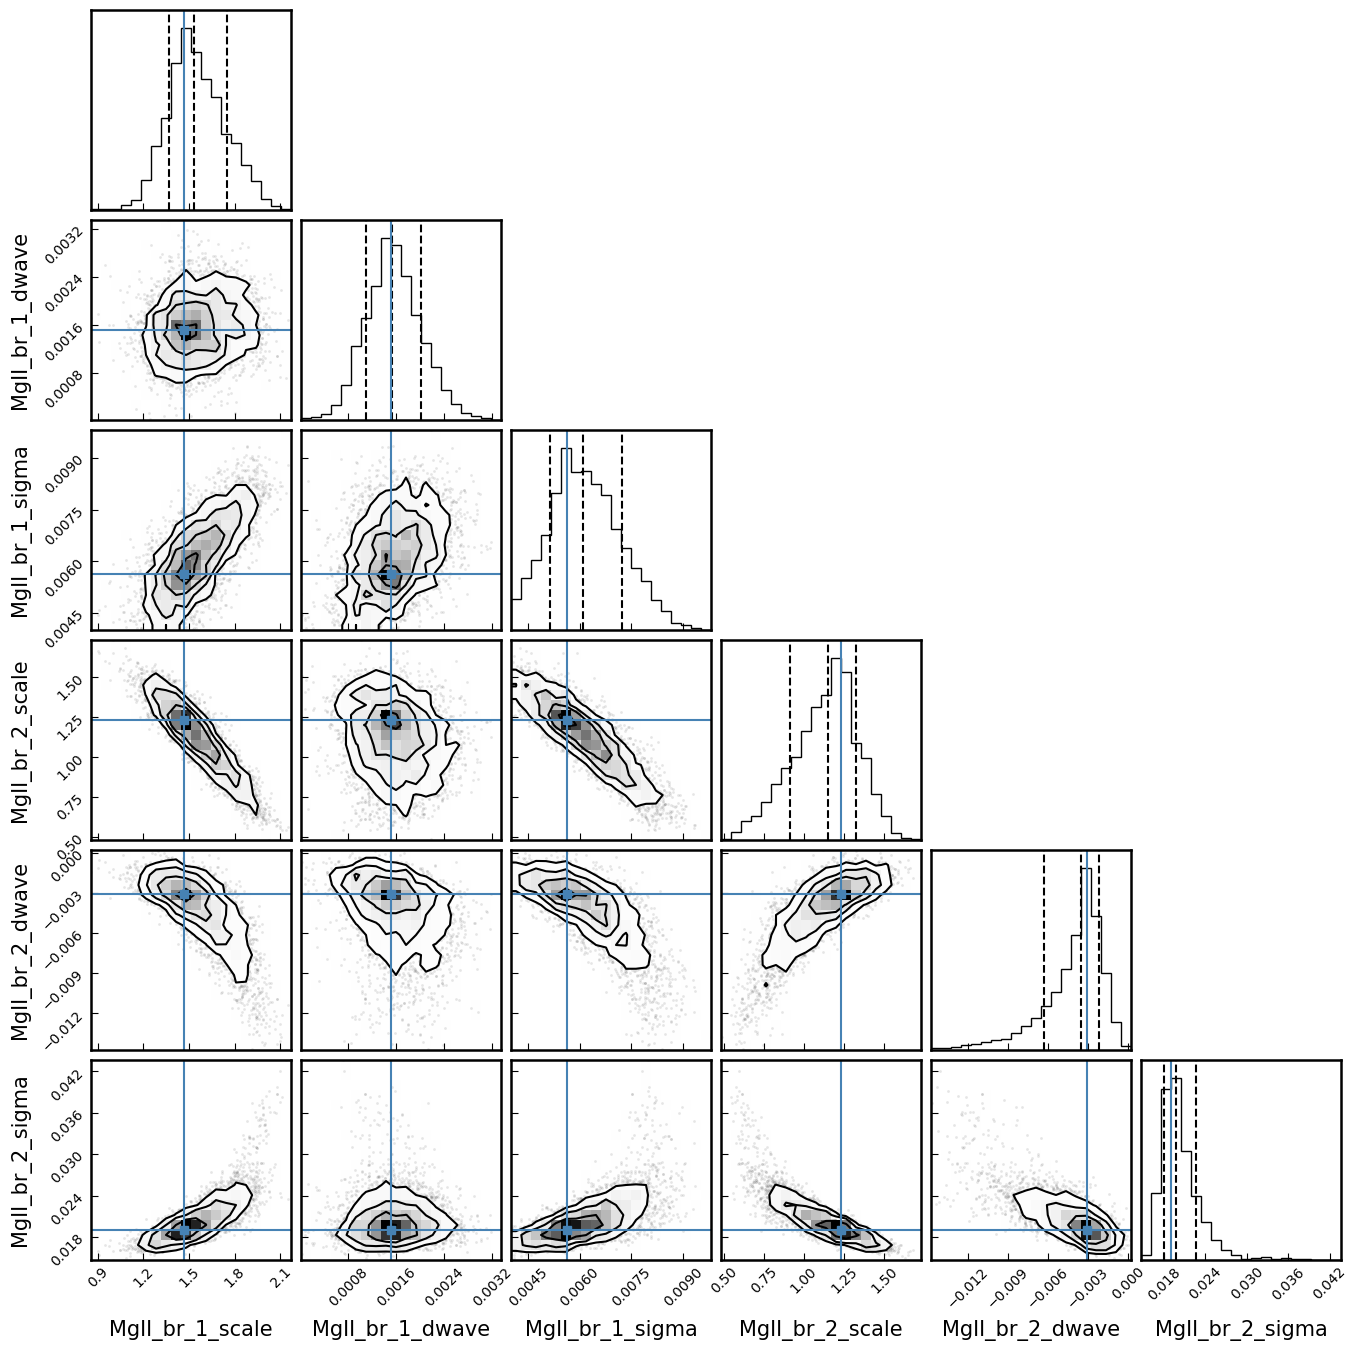

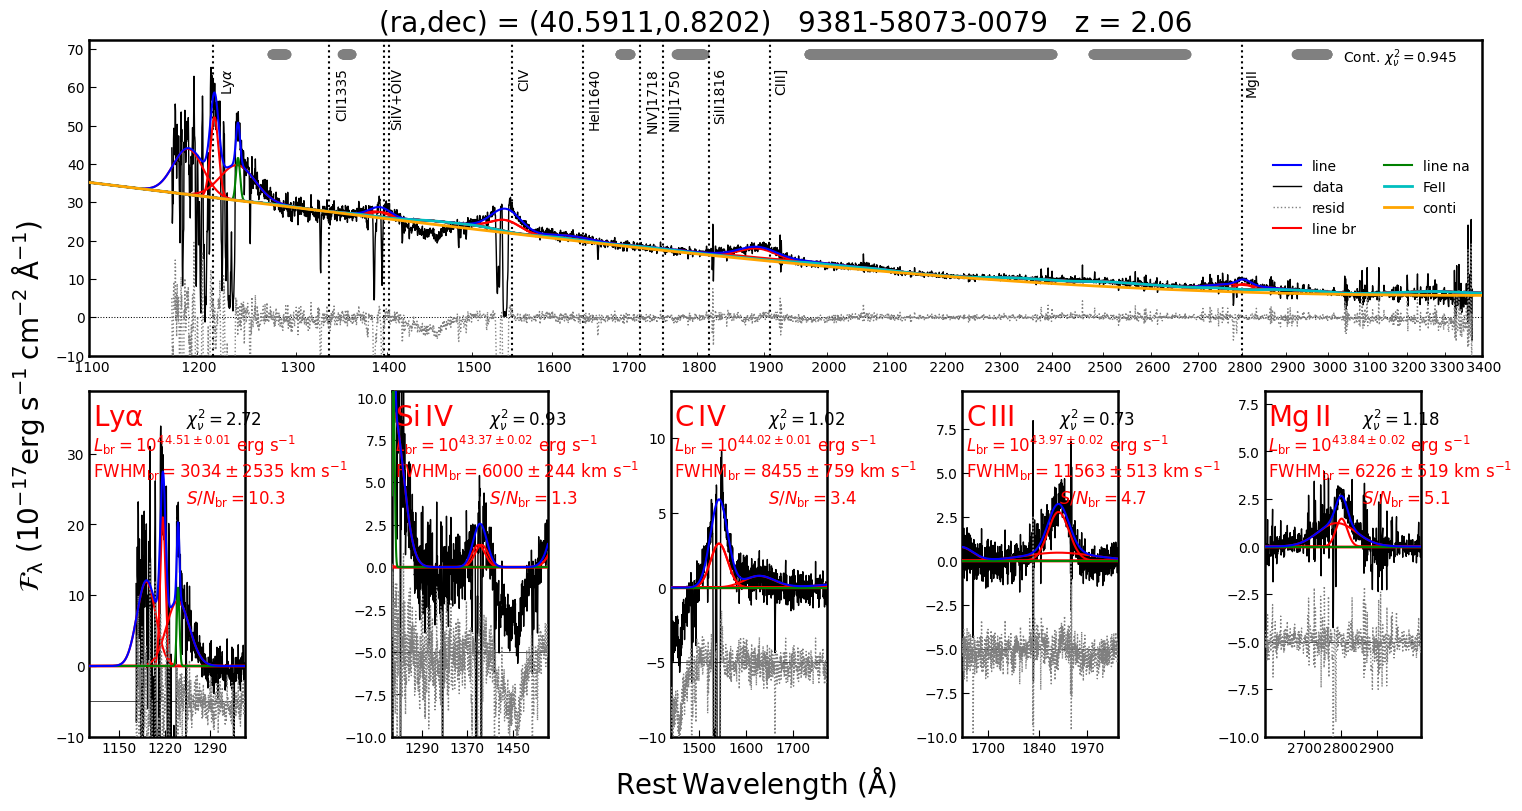

In [92]:
q_mcmc = QSOFit(lam, flux, err, z, epoch, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_name)

start = timeit.default_timer()
# Do the fitting
q_mcmc.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
           wave_mask=None, decompose_host=True, host_prior=False, decomp_na_mask=True, npca_gal=5, npca_qso=10, qso_type='CZBIN1',
           Fe_uv_op=True, poly=True, rej_abs_conti=False, \
           MCMC=True, epsilon_jitter=0, nburn=10, nsamp=400, nthin=10, linefit=True, save_result=True, \
           plot_fig=True, save_fig=False, plot_corner=True, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None,
           verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

When ``MCMC=True`` or ``MC=True`` (they cannot both be ``True``), the 1$\sigma$ uncertainties (from the 16th and 84th percentiles) are added to the results (the "_err" parameters). The initial MLE fit will again be computed and is used as the starting point for emcee.

You may need to turn off/on continuum fitting components or adjust the parameter bounds as neccessary to fit your data. For more details, such as to view the acceptance fraction, use ``verbose=True``.

__View results:__ The results arrays will include the uncertainties on each parameter only if MCMC is used.

In [94]:
# Continuum fitting results
print(q_mcmc.conti_result_name)
print('')
print(q_mcmc.conti_result)

['ra' 'dec' 'plateid' 'MJD' 'fiberid' 'redshift' 'SN_ratio_conti'
 'Fe_uv_norm' 'Fe_uv_norm_err' 'Fe_uv_FWHM' 'Fe_uv_FWHM_err' 'Fe_uv_shift'
 'Fe_uv_shift_err' 'Fe_op_norm' 'Fe_op_norm_err' 'Fe_op_FWHM'
 'Fe_op_FWHM_err' 'Fe_op_shift' 'Fe_op_shift_err' 'PL_norm' 'PL_norm_err'
 'PL_slope' 'PL_slope_err' 'Balmer_norm' 'Balmer_norm_err' 'Balmer_Te'
 'Balmer_Te_err' 'Balmer_Tau' 'Balmer_Tau_err' 'conti_a_0' 'conti_a_0_err'
 'conti_a_1' 'conti_a_1_err' 'conti_a_2' 'conti_a_2_err' 'L1350'
 'L1350_err' 'L2500' 'L2500_err' 'Fe_flux_2240_2650'
 'Fe_flux_2240_2650_err']

['40.59114399999999' '0.820204' '9381' '58073' '79' '2.06'
 '8.45692719722068' '0.20257462374217994' '0.03255270461251676'
 '10378.165747651836' '2446.25577893874' '-0.003126978517586308'
 '0.0012926663477065212' '0.0' '0.0' '3000.0' '0.0' '0.0' '0.0'
 '6.02947358707695' '0.10867835888030175' '2.587550819639165'
 '0.3895067221514279' '0.0' '0.0' '15000.0' '0.0' '0.5' '0.0'
 '-7076.042190048601' '961.0095307614415' '2.00501623087

In [95]:
# Gaussian fitting results
print(q_mcmc.gauss_result_name)
print('')
print(q_mcmc.gauss_result)

['Lya_br_1_scale' 'Lya_br_1_scale_err' 'Lya_br_1_centerwave'
 'Lya_br_1_centerwave_err' 'Lya_br_1_sigma' 'Lya_br_1_sigma_err'
 'Lya_br_2_scale' 'Lya_br_2_scale_err' 'Lya_br_2_centerwave'
 'Lya_br_2_centerwave_err' 'Lya_br_2_sigma' 'Lya_br_2_sigma_err'
 'Lya_br_3_scale' 'Lya_br_3_scale_err' 'Lya_br_3_centerwave'
 'Lya_br_3_centerwave_err' 'Lya_br_3_sigma' 'Lya_br_3_sigma_err'
 'NV1240_1_scale' 'NV1240_1_scale_err' 'NV1240_1_centerwave'
 'NV1240_1_centerwave_err' 'NV1240_1_sigma' 'NV1240_1_sigma_err'
 'SiIV_OIV1_1_scale' 'SiIV_OIV1_1_scale_err' 'SiIV_OIV1_1_centerwave'
 'SiIV_OIV1_1_centerwave_err' 'SiIV_OIV1_1_sigma' 'SiIV_OIV1_1_sigma_err'
 'SiIV_OIV2_1_scale' 'SiIV_OIV2_1_scale_err' 'SiIV_OIV2_1_centerwave'
 'SiIV_OIV2_1_centerwave_err' 'SiIV_OIV2_1_sigma' 'SiIV_OIV2_1_sigma_err'
 'CIV_br_1_scale' 'CIV_br_1_scale_err' 'CIV_br_1_centerwave'
 'CIV_br_1_centerwave_err' 'CIV_br_1_sigma' 'CIV_br_1_sigma_err'
 'CIV_br_2_scale' 'CIV_br_2_scale_err' 'CIV_br_2_centerwave'
 'CIV_br_2_centerwave

To get the results of each MC or MCMC sample, use ``gauss_result_all``. You can then use the ``line_prop`` function to get the line properties for each sample, and take median values of each parameter's samples. The parameters in ``gauss_result`` are used for the MLE solution for MCMC (or just one MC sample), and may not be the same as the median of the posterior distributions!

In [96]:
# Gaussian fitting results
print(q_mcmc.gauss_result_name[::2])
print('')
print(q_mcmc.gauss_result_all)
print(np.shape(q_mcmc.gauss_result_all))

['Lya_br_1_scale' 'Lya_br_1_centerwave' 'Lya_br_1_sigma' 'Lya_br_2_scale'
 'Lya_br_2_centerwave' 'Lya_br_2_sigma' 'Lya_br_3_scale'
 'Lya_br_3_centerwave' 'Lya_br_3_sigma' 'NV1240_1_scale'
 'NV1240_1_centerwave' 'NV1240_1_sigma' 'SiIV_OIV1_1_scale'
 'SiIV_OIV1_1_centerwave' 'SiIV_OIV1_1_sigma' 'SiIV_OIV2_1_scale'
 'SiIV_OIV2_1_centerwave' 'SiIV_OIV2_1_sigma' 'CIV_br_1_scale'
 'CIV_br_1_centerwave' 'CIV_br_1_sigma' 'CIV_br_2_scale'
 'CIV_br_2_centerwave' 'CIV_br_2_sigma' 'HeII1640_br_1_scale'
 'HeII1640_br_1_centerwave' 'HeII1640_br_1_sigma' 'OIII1663_br_1_scale'
 'OIII1663_br_1_centerwave' 'OIII1663_br_1_sigma' 'CIII_br_1_scale'
 'CIII_br_1_centerwave' 'CIII_br_1_sigma' 'CIII_br_2_scale'
 'CIII_br_2_centerwave' 'CIII_br_2_sigma' 'MgII_br_1_scale'
 'MgII_br_1_centerwave' 'MgII_br_1_sigma' 'MgII_br_2_scale'
 'MgII_br_2_centerwave' 'MgII_br_2_sigma']

[[9.19647123 7.12300357 0.0141984  ... 1.23822329 7.93384305 0.01937985]
 [9.19480675 7.12304063 0.01421871 ... 1.25501693 7.93372827 0.0190

In [97]:
# line fitting results
print(q_mcmc.line_result_name)
print('')
print(q_mcmc.line_result)

['1_complex_name' '1_line_status' '1_line_min_chi2' '1_line_bic'
 '1_line_red_chi2' '1_niter' '1_ndof' '2_complex_name' '2_line_status'
 '2_line_min_chi2' '2_line_bic' '2_line_red_chi2' '2_niter' '2_ndof'
 '3_complex_name' '3_line_status' '3_line_min_chi2' '3_line_bic'
 '3_line_red_chi2' '3_niter' '3_ndof' '4_complex_name' '4_line_status'
 '4_line_min_chi2' '4_line_bic' '4_line_red_chi2' '4_niter' '4_ndof'
 '5_complex_name' '5_line_status' '5_line_min_chi2' '5_line_bic'
 '5_line_red_chi2' '5_niter' '5_ndof' 'Lya_br_1_scale'
 'Lya_br_1_scale_err' 'Lya_br_1_centerwave' 'Lya_br_1_centerwave_err'
 'Lya_br_1_sigma' 'Lya_br_1_sigma_err' 'Lya_br_2_scale'
 'Lya_br_2_scale_err' 'Lya_br_2_centerwave' 'Lya_br_2_centerwave_err'
 'Lya_br_2_sigma' 'Lya_br_2_sigma_err' 'Lya_br_3_scale'
 'Lya_br_3_scale_err' 'Lya_br_3_centerwave' 'Lya_br_3_centerwave_err'
 'Lya_br_3_sigma' 'Lya_br_3_sigma_err' 'NV1240_1_scale'
 'NV1240_1_scale_err' 'NV1240_1_centerwave' 'NV1240_1_centerwave_err'
 'NV1240_1_sigma' 'NV1

__Step 4: Get all models for the whole spectrum__ <br>
Continue to look at this section and below if you want to do some further calculations based on the fitting results. Here, we show how to extract different models from our fitting results, such as continuum model, emission line models and host galaxy component. Note that the emission regions of host galaxy template should be blocked, e.g., H$\alpha$ [6540, 6590].

There are two ways to calculate the Fe II flux within given ranges:
1. If you want the program calculate the Fe II flux automatically and documented them in result file, you can use the parameter `Fe_flux_range` in `Fit()` to assign ranges.
2. We also provide build-in function `Get_Fe_flux` to calculate the Fe II flux directly after you finished the fitting part.

Fe flux within a specific range: 
Fe_flux_1200_3000: 1009.1303309555113


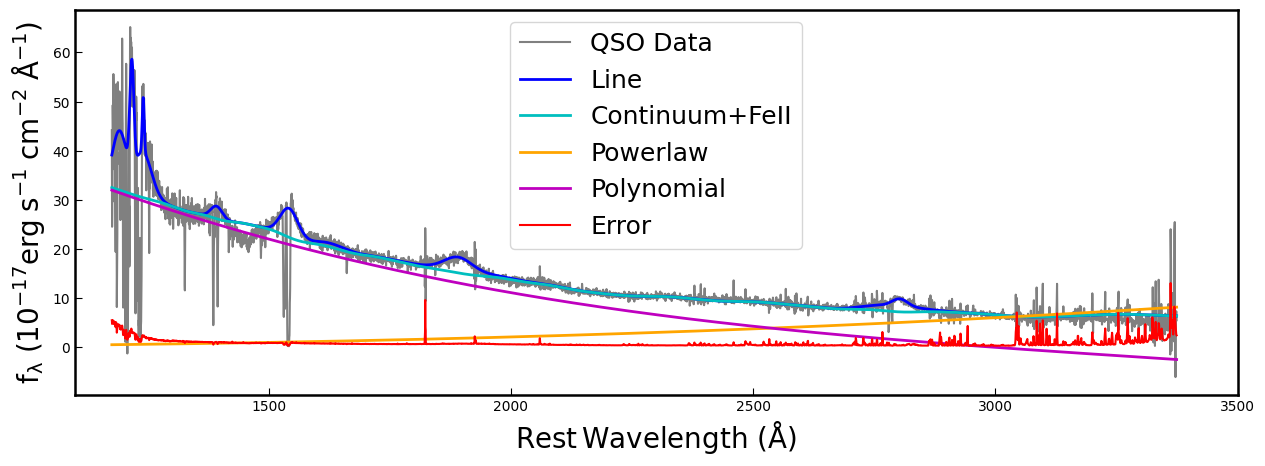

In [98]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the quasar rest frame spectrum after removed the host galaxy component
ax.plot(q_mcmc.wave, q_mcmc.flux, 'grey', label='QSO Data')

# Skip the error results before plotting
if q_mcmc.MCMC == True:
    gauss_result = q_mcmc.gauss_result[::2]
else:
    gauss_result = q_mcmc.gauss_result

# To plot the whole model, we use Manygauss to show the line fitting results saved in gauss_result
ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result) + q_mcmc.f_conti_model, 'b', label='Line',
        lw=2)
ax.plot(q_mcmc.wave, q_mcmc.f_conti_model, 'c', lw=2, label='Continuum+FeII')
ax.plot(q_mcmc.wave, q_mcmc.f_pl_model, 'orange', lw=2, label='Powerlaw')
ax.plot(q_mcmc.wave, q_mcmc.f_poly_model, 'm', lw=2, label='Polynomial')
#ax.plot(q_mcmc.wave, q_mcmc.PL_poly_BC, 'orange', lw=2, label='Continuum')
#ax.plot(q_mcmc.wave, q_mcmc.host, 'm', lw=2, label='Host')
ax.plot(q_mcmc.wave, q_mcmc.err, 'r', label='Error')
plt.legend()

ax.set_xlim(1100, 3500)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

#print('optical Fe flux (10^(-17) erg/s/cm^2): ' + q_mcmc.conti_result[q_mcmc.conti_result_name=='Fe_flux_4435_4685'][0])

Fe_flux_result, Fe_flux_type, Fe_flux_name = q_mcmc.Get_Fe_flux(np.array([1200, 3000]))
print('Fe flux within a specific range: \n' + Fe_flux_name[0] + ': ' + str(Fe_flux_result[0]))


__Step 5: Get models for each line complex (NOT updated for J0242)__ <br>
All the line parameters are in the gauss_result, in the same order as in the parameter file. For each Gaussian, three parameter (scale, ln lambda, ln sigma) are saved.
If you want to filter the line below or above 1200 km/s (ln sigma = 0.00169), the function ``CalFWHM`` can be used as following.

The line_prop is designed to calculate the broad line properties, not for the narrow line. It is saved in the line_result property, but can be computed again.

Broad Hb:
FWHM (km/s) 6221.4
Sigma (km/s) 2303.1
EW (A) 56.8
Peak (A) 4874.2
Area (10^(-17) erg/s/cm^2) 841.2

Narrow [OIII]5007:
FWHM (km/s) 550.1
Sigma (km/s) 228.2
EW (A) 46.8
Peak (A) 5006.7
Area (10^(-17) erg/s/cm^2) 668.6


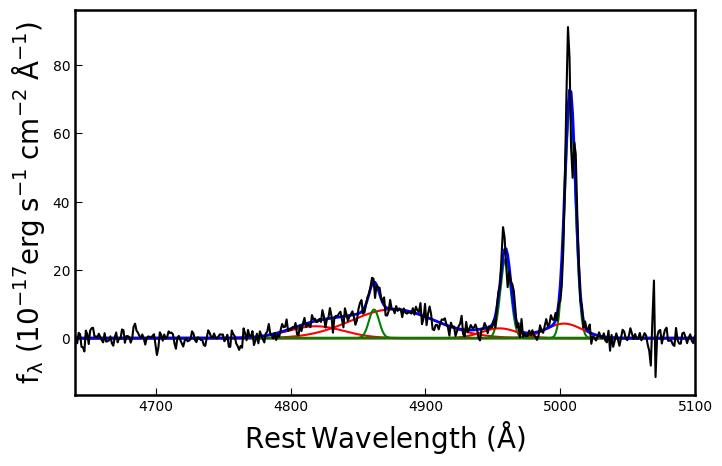

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

if q_mcmc.MCMC:
    gauss_result = q_mcmc.gauss_result[::2]
else:
    gauss_result = q_mcmc.gauss_result

# Plot individual line components
for p in range(int(len(gauss_result) / 3)):
    if q_mcmc.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
        color = 'g'  # narrow
    else:
        color = 'r'  # broad
    ax.plot(q_mcmc.wave, q_mcmc.Onegauss(np.log(q_mcmc.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

# Plot total line model
ax.plot(q_mcmc.wave, q_mcmc.Manygauss(np.log(q_mcmc.wave), gauss_result), 'b', lw=2)
ax.plot(q_mcmc.wave, q_mcmc.line_flux, 'k')
ax.set_xlim(4640, 5100)
ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

"""
Line properties
"""

# The line_prop function is used to calculate the broad line properties
# (defined, by default, as ln sigma > 0.00169 (1200 km/s) )

sample_index = -1 # Added by PBH

# OLD WAY: If you want to calculate the paramters of broad Hb
# then find all the broad Hb component, i.e., Hb_br_[1,2,3]_[scale,centerwave,sigma]
# for here q.line_result_name[12:15], q.line_result[12:15] is the broad Hb
# If MCMC=False, this would be:
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[12:15], 'broad')

# NEW WAY: using line_prop_from_name convenience function
fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name('Hb_br', 'broad')

print("Broad Hb:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("")

# OLD WAY: If you want to calculate the  the narrow [OIII]5007
# If MCMC=False, this would be:
# the coresponding parameters are  q.line_result_name[21:24], q.line_result[21:24]
# fwhm, sigma, ew, peak, area = q.line_prop(q.linelist[6][0], q.line_result[21:24], 'narrow')

fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name('OIII5007c', 'narrow')

print("Narrow [OIII]5007:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("Area (10^(-17) erg/s/cm^2)", np.round(area, 1))

__Determine number of broad components for a line (NOT updated for J0242)__:

If you want to determine how many Gaussian components are statistically justified for a broad emission line given the S/N, run ``PyQSOFit`` multiple times and use the [Bayesian information criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) to determine it.

Fitting broad H$\alpha$ with 1 components.
Delta BIC = inf


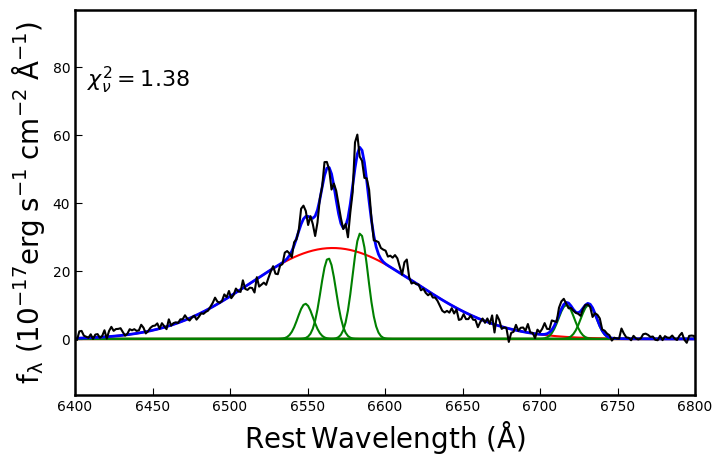

Fitting broad H$\alpha$ with 2 components.
Delta BIC = 81.1


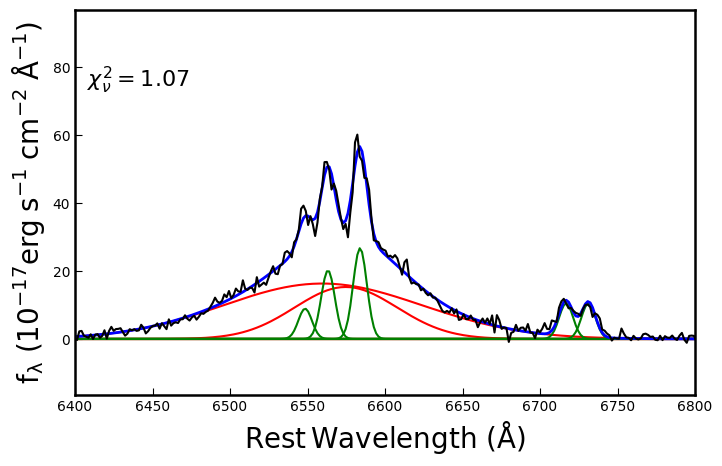

Fitting broad H$\alpha$ with 3 components.
Delta BIC = 31.7


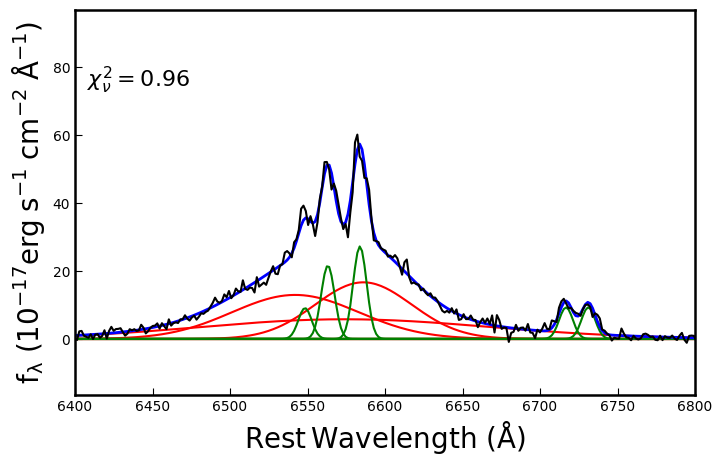

Fitting broad H$\alpha$ with 4 components.
Delta BIC = 7.5
3 components is prefered


In [21]:
# Required
data = fits.open(os.path.join(path_to_data, 'data/spec-0332-52367-0639.fits'))
lam = 10 ** data[1].data['loglam']  # OBS wavelength [A]
flux = data[1].data['flux']  # OBS flux [erg/s/cm^2/A]
err = 1 / np.sqrt(data[1].data['ivar'])  # 1 sigma error
z = data[2].data['z'][0]  # Redshift
epoch = '52367' # Epoch label

# Optional
ra = data[0].header['plug_ra']  # RA
dec = data[0].header['plug_dec']  # DEC
plateid = data[0].header['plateid']  # SDSS plate ID
mjd = data[0].header['mjd']  # SDSS MJD
fiberid = data[0].header['fiberid']  # SDSS fiber ID

ngauss_max = 5  # stop at 5 components
bic_last = np.inf

# Number of Gaussians to try loop
for ngauss in range(1, ngauss_max):

    print(fr'Fitting broad H$\alpha$ with {ngauss} components.')

    # Change the number of Gaussians for the Ha line in the line parameter file

    hdu1_new = hdu1.copy()
    if 'Ha_br' in hdu1.data['linename']:
        hdu1.data['ngauss'][hdu1.data['linename'] == 'Ha_br'] = ngauss
    hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
    hdu_list.writeto(os.path.join(path_out, param_file_name), overwrite=True)

    # Do the fitting
    q = QSOFit(lam, flux, err, z, epoch, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_name)

    q.Fit(name=None, nsmooth=1, deredden=True, reject_badpix=False, wave_range=None, \
          wave_mask=None, decompose_host=True, host_prior=True, decomp_na_mask=True, \
          npca_gal=5, npca_qso=10, qso_type='CZBIN1',\
          Fe_uv_op=True, poly=True, BC=False, rej_abs_conti=False, rej_abs_line=False, \
          initial_guess=None, MCMC=False, nburn=20, nsamp=200, nthin=10, linefit=True, \
          save_result=False, plot_fig=False, verbose=False)

    mask_Ha_bic = q.line_result_name == '2_line_min_chi2'

    bic = float(q.line_result[mask_Ha_bic][0])

    print(f'Delta BIC = {np.round(bic_last - bic, 1)}')

    # Stop condition of Delta BIC = 10 is a good rule of thumb
    if bic_last - bic < 10:
        print(f'{ngauss-1} components is prefered')
        break

    bic_last = bic

    # Plot the result
    if q.MCMC:
        gauss_result = q.gauss_result[::2]
    else:
        gauss_result = q.gauss_result

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    # Plot individual line components
    for p in range(len(gauss_result) // 3):
        if q.CalFWHM(gauss_result[3 * p + 2]) < 1200:  # < 1200 km/s narrow
            color = 'g'  # narrow
        else:
            color = 'r'  # broad
        ax.plot(q.wave, q.Onegauss(np.log(q.wave), gauss_result[p * 3:(p + 1) * 3]), color=color)

    # Plot total line model
    ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=2)
    ax.plot(q.wave, q.line_flux, 'k')
    ax.set_xlim(6400, 6800)
    ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
    ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

    c = 1  # Ha
    ax.text(0.02, 0.80, r'$\chi ^2_\nu=$' + str(np.round(float(q.comp_result[c * 7 + 4]), 2)),
            fontsize=16, transform=ax.transAxes)

    plt.show()